# Hotel Lift Traffic: Monte Carlo simulation

In [37]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import logging
import random
import math

logging.getLogger().setLevel(logging.DEBUG)
logging.debug("TEST")

%matplotlib inline

In [2]:
# make a rules using graph network
lift_number = 4
number_of_floor = 20
conference_room_floor = 2

In [192]:
class RoomType:
    def __init__(self,name_type:str,capacity:int):
        self._name_type=name_type
        self._capacity=capacity
    
    @property
    def name_type(self):
        return self._name_type
    
    @property
    def capacity(self):
        return self._capacity

class Room(RoomType):
    """
    def __init__(self,number: str,room_type: RoomType):
        self._room_type = room_type
        self._number = number        
        
    @property
    def room_type(self):
        return self._room_type
    """
        
    def __init__(self,number: str,name:str,capacity:int,floor:HotelFloor):
        RoomType.__init__(self,name,capacity)
        self._number = number
        self._occupied = False
        self._attendance = []
        self._floor = floor
    
    @property
    def floor(self):
        return self._floor
    
    @property
    def number(self):
        return self._number
                    
    @property
    def occupied(self):
        return self._occupied

    """
    @occupied.setter
    def occupied(self,status:bool):
        self._occupied = status
    """
    
    @property
    def attendance(self):
        return self._attendance
    
    @property
    def attendance_number(self):
        return len(self._attendance)
    
    @property
    def occupied_status(self):
        return "occupied" if self.occupied else "empty"
    
    def attendance_checkin(self,person:Person):
        self.attendance.append(person)
        # There is a person checkin, set occupancy status of this room into True
        if self.attendance_number > 0:
            self._occupied = True
    
    def attendance_checkout(self,person:Person):
        self.attendance.remove(person)
        # if attendance number is zero than the room is empty
        if self.attendance_number == 0:
            self._occupied = False

    def __repr__(self):
        return("Room {}, Type: {}, Capacity: {}, Status: {}".format(self.number,self.name_type,self.capacity,self.occupied_status))

        
class RandomDist():
    def __init__(self,name):
        self._name = name

    @property
    def name(self):
        return self._name
    
    def random(self):
        None
    
class GaussianDist(RandomDist):
    def __init__(self,mu:float,sigma:float,low:float,high:float):
        RandomDist.__init__(self,"Gaussian")
        self._mu = mu
        self._sigma = sigma
        self._low = low
        self._high = high
        
    def random(self):
        x = self._low - 1
        while x < self._low or x > self._high:
            x = random.gauss(self._mu,self._sigma)                        
        return x
    
class GaussianDiscrete(RandomDist):
    def __init__(self,mu:float,sigma:float,low:float,high:float):
        RandomDist.__init__(self,"GaussianDiscrete")
        self._mu = mu
        self._sigma = sigma
        self._low = low
        self._high = high
        
    def random(self):
        x = self._low - 1
        while x < self._low or x > self._high:
            x = math.round(random.gauss(self._mu,self._sigma))
        return x

class CapacityLimit:
    def __init__(self,capacity = 0):
        self._capacity = capacity
    
    @property
    def capacity(self):
        return self._capacity

class Floor(CapacityLimit):
    def __init__(self,capacity = 0):
        CapacityLimit.__init__(self,capacity)
    
class HotelFloor(Floor):
    def __init__(self,floor_name:str,rooms_floor_count: dict,room_types: dict):
        self._rooms = {}
        number = 1
        self._floor_name = floor_name
        
        capacity = 0
        # initialize room type
        for key in rooms_floor_count:
            self._rooms[key] = []
        # create the Room object
        for key in rooms_floor_count:
            for i in range(rooms_floor_count[key]):
                room = Room(str(floor_name)+str(number),room_types[key].name_type,room_types[key].capacity,floor=self)
                self._rooms[key].append(room)
                capacity += room.capacity
                number+=1
        
        self._total_rooms = number
        
        Floor.__init__(self,capacity)
    
    @property
    def rooms(self):
        return self._rooms
    
    @property
    def floor_name(self):
        return self._floor_name
    
    def __repr__(self):
        return "Floor: {}, Total Rooms: {}".format(self.floor_name,self._total_rooms)
    
        
class Lift(CapacityLimit):    
    def __init__(self,name:str,average_speed:int=1,
                 floor_configuration:dict={},capacity:int = 0,position:int = 0,
                 max_waiting_time:int=10):
        CapacityLimit.__init__(self,capacity)
        self._name = name
        self._position = position
        self._graph = nx.DiGraph()
        self._attendance = 0
        self._max_waiting_time = 10
        
        # Random distribution for maximum waiting time
        # it should use skewed distribution
        # This will effect the lift door closing time
        
        self._random_gauss = GaussianDist(mu = self.max_waiting_time/2, sigma=5, low=1, high=self.max_waiting_time)

        if len(floor_configuration) > 0:
            # floor configuration is exist
            # we can make a fully customized lift graph
            logging.debug(floor_configuration)
            self._served_floor = floor_configuration["floor"]
            for i,x in enumerate(floor_configuration["floor"]):
                self.graph.add_node(x)
                if i > 0:
                    previous_floor = floor_configuration["floor"][i-1]
                    speed = floor_configuration["speed"][i-1]
                    self.graph.add_edge(previous_floor,x,attr={"speed": speed, "dir": "up"})
                    self.graph.add_edge(x,previous_floor,attr={"speed": speed, "dir": "down"})
    
    @property
    def max_waiting_time(self):
        return self._max_waiting_time
    
    @property
    def random_gauss(self) -> GaussianDist :
        return self._random_gauss
    
    def gen_close_door(self) -> int :
        """
        Generate close door for simulation
        """
        return math.ceil(self._random_gauss.random())
                    
    @property
    def waiting_time(self) -> int :
        return self._waiting_time
                    
    @property
    def name(self) -> str :
        return self._name
    
    @property
    def position(self) -> int : 
        return self._position
    
    @position.setter
    def position(self,position) -> int :
        self._position = position
        
    @property
    def graph(self) -> nx.DiGraph : 
        return self._graph
    
    @property
    def attendance(self) -> int : 
        return self._attendance

    @property
    def served_floor(self) -> list:
        return self._served_floor
    
    @attendance.setter
    def attendance(self, new_att:int):
        if new_att > self.capacity:
            raise Exception("Attendance reach it's maximum capacity: {}".format(self.capacity))
        if new_att < 0:
            raise Exception("Attendance can't be lower than zero: {}".format(new_att))
        """
        if self.attendance + new_att > self.capacity:
            throw Exception("Attendance reach it's maximum capacity: {}".format(self.capacity))
        """
        self._attendance = new_att
    
    def add_attendance(self,new_att: int):
        self.attendance+=new_att
    
    def pop_attendance(self,drop_att: int):
        self.attendance-=drop_att            
    
    def go_up(self):
        edge = self.graph.edge[self.position]
        for target_node in edge:
            if edge[target_node]["attr"]["dir"] == "up":
                self.position = target_node
        return self.position
    
    def go_down(self):
        edge = self.graph.edge[self.position]
        for target_node in edge:
            if edge[target_node]["attr"]["dir"] == "down":
                self.position = target_node
        return self.position

    def __repr__(self):
        #print(self.served_floor)
        return "Lift {}, capacity: {}, attendance: {}, position: {}, serve: {}".format(self.name,self.capacity,self.attendance,self.position,",".join([str(x) for x in self.served_floor])) 
        
        
number_of_floor = 20

custom_floor = [0,10]
custom_floor.extend(range(11,number_of_floor))
custom_speed = [10]
custom_speed.extend([1 for x in range(10,number_of_floor-1)])


lift_floor_configuration = {
    # speed 1 for every floor
    0: { "floor": range(0,number_of_floor), "speed": [1 for x in range(number_of_floor-1)] },
    1: { "floor": range(0,number_of_floor), "speed": [1 for x in range(number_of_floor-1)] }, 
    2: { "floor": range(0,int(number_of_floor/2)), "speed": [1 for x in range(0,int(number_of_floor/2)-1)] },
    3: { "floor": range(0,int(number_of_floor/2)), "speed": [1 for x in range(0,int(number_of_floor/2)-1)] },
    4: { "floor": custom_floor, "speed": custom_speed },
    5: { "floor": custom_floor, "speed": custom_speed }
}

room_types_list = ["single","double","deluxe"]

room_types = {
    "single": RoomType("single",2),
    "double": RoomType("double",2),
    "deluxe": RoomType("deluxe",4),
}

rooms_floor_count = {
    "single" : 20,
    "double" : 20,
    "deluxe" : 10
}    
    
class HotelLift():    
    def __init__(self,number_of_floor:int,number_of_lift:int,rooms_floor_count,room_types:dict):
        self._floors = []
        self._rooms = []
        self._total_capacity = 0
        for x in range(number_of_floor):
            floor = HotelFloor(x,rooms_floor_count,room_types)
            self._total_capacity += floor.capacity
            self._floors.append(floor)
            #print(floor.rooms)
            for rooms in floor.rooms.values():
                #print(rooms)
                self._rooms.extend(rooms)
        
        self._lifts = {}
        for x in lift_floor_configuration:
            logging.debug(x)
            config = lift_floor_configuration[x]
            self.lifts[x] = Lift(name=x,floor_configuration=config,capacity=20,position=0)
            
        """
        for x in range(number_of_lift):
            lift = Lift(x,20,0)
            for y in range(number_of_floor):
                lift.graph.add_node(y)
                if y > 0:
                    lift.graph.add_edge(y-1,y)
                    lift.graph.add_edge(y,y-1)

            self._lifts.append(lift)     
        """
        
    @property
    def lifts(self):
        return self._lifts
    
    @property
    def floors(self):
        return self._floors
    
    @property
    def rooms(self):
        return self._rooms
    
    @property
    def total_capacity(self):
        return self._total_capacity
    
    def __repr__(self):
        output = ""
        for x in self.lifts.values():
            output += x.__repr__() + "\n"
        return output
                        
        
def create_lift(number_of_floor:int):
    one_lift = nx.DiGraph()
    for x in range(number_of_floor):
        one_lift.add_node(x)
        if x > 0:
            one_lift.add_edge(x-1,x)
            one_lift.add_edge(x,x-1)
    return one_lift

(array([   1.,    0.,    1.,    5.,   12.,   24.,   37.,   66.,   82.,
         120.,  138.,  154.,  117.,  100.,   62.,   41.,   25.,    9.,
           4.,    2.]),
 array([-21058.35960422, -17189.40383897, -13320.44807371,  -9451.49230846,
         -5582.53654321,  -1713.58077795,   2155.3749873 ,   6024.33075255,
          9893.28651781,  13762.24228306,  17631.19804831,  21500.15381356,
         25369.10957882,  29238.06534407,  33107.02110932,  36975.97687458,
         40844.93263983,  44713.88840508,  48582.84417034,  52451.79993559,
         56320.75570084]),
 <a list of 20 Patch objects>)

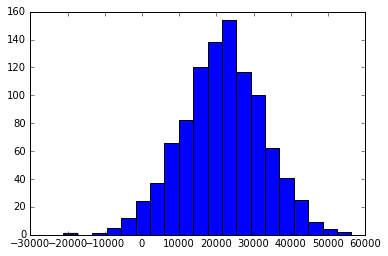

In [193]:
# moving time generator simulation
y = []
for i in range(1000):
    #y.append(x.lifts[0].gen_close_door())
    #print(i)
    y.append(random.gauss(21600,21600/2))
plt.hist(y,bins=20)

In [194]:
class Person():
    _target_dest = ["room","outside","conference","dining"]
    _status = ["idle","go_lift","waiting_lift","in_lift","on_move"]
    
    # Create a DAG for moving behaviour
    
    _nodes = ["room","go_lift","waiting_lift","in_lift","outside"]    
    
    _move_graph = nx.DiGraph()
    for node in _nodes:
        _move_graph.add_node(node)
    
    _move_graph.add_edge("room","go_lift")
    _move_graph.add_edge("go_lift","waiting_lift")
    _move_graph.add_edge("waiting_lift","in_lift")    
    _move_graph.add_edge("in_lift","outside")
    _move_graph.add_edge("outside","go_lift")
    _move_graph.add_edge("in_lift","room")        
    
    def __init__(self,name:str,move_time:int,outside_time:int,schedule={},capacity_unit=1):
        self._name = name
        self._capacity_unit = capacity_unit
        self._schedule = schedule
        self._move_time = move_time
        self._outside_time = outside_time        
        self._random_move_time = GaussianDist(mu=move_time,sigma=move_time/2,low=0,high=move_time*2)
        self._random_outside_time = GaussianDist(mu=outside_time,sigma=outside_time/2,low=0,high=outside_time*2)
        self._next_move = 0

        """
        status for a person is
        
        """
        self._status = "idle"
        self._position = "outside"
        self._target = ""
        self._action = ""
        self._moving_path = []
        
    @property
    def capacity_unit(self):
        return self._capacity_unit
    
    @property
    def name(self):
        return self._name
    
    @property
    def move_time(self):
        return self._move_time
    
    @property
    def next_move_schedule(self):
        return self._next_move
    
    @property
    def status(self):
        return self._status       
    
    @property
    def perform_move(self):
        """
        This function will be a counter time for moving
        every time this function called, moving time will be reduced
        and if it's reach zero it will perform the moving
        action
        """
        if self._move_time == 0 and self._moving_path[0] == self._position:
            # pop the value
            self._moving_path.pop(0)
            self._action = self._moving_path[0]
        
        if len(self._moving_path)==0:
            self.generate_next_move()
                    
        if self._move_time > 0:
            self._move_time-=1        
    
    @property
    def target(self):
        return self._target
    
    @property
    def position(self):
        return self._position
    
    @position.setter
    def position(self,pos:str):
        self._position = pos
    
    @property
    def action(self):
        return self._action
    
    @property
    def generate_next_move(self):
        if self._position == "room":
            self._next_move = self._random_move_time.random()
            self._target = "outside"
        else:
            self._next_move = self._random_outside_time.random()
            self._target = "room"
        
        self._moving_path = nx.shortest_path(self._move_graph,self._position,self._target)        

    
class Attendance(Person):
    def __init__(self,room:Room,name:str,move_time:int,outside_time:int,schedule:dict={},capacity_unit:int=1):
        Person.__init__(self,name,move_time=move_time,outside_time=outside_time,capacity_unit=capacity_unit,schedule=schedule)
        self._room = room
    
    @property
    def room(self):
        return self._room
    
    @room.setter
    def room(self,room:Room):
        self._room = room
    
    def __repr__(self):
        return "name: {}, room: {}".format(self.name,self.room)

In [195]:
#HotelFloor(rooms_floor_count,room_types)
hotel = HotelLift(20,4,rooms_floor_count,room_types)
print(hotel)
len(hotel.rooms)

Lift 0, capacity: 20, attendance: 0, position: 0, serve: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Lift 1, capacity: 20, attendance: 0, position: 0, serve: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Lift 2, capacity: 20, attendance: 0, position: 0, serve: 0,1,2,3,4,5,6,7,8,9
Lift 3, capacity: 20, attendance: 0, position: 0, serve: 0,1,2,3,4,5,6,7,8,9
Lift 4, capacity: 20, attendance: 0, position: 0, serve: 0,10,11,12,13,14,15,16,17,18,19
Lift 5, capacity: 20, attendance: 0, position: 0, serve: 0,10,11,12,13,14,15,16,17,18,19



1000

In [196]:
class InitialGenerator():
    def __init__(self,room_stack: list,room_occupancy_pctg:float,move_time:int,outside_time:int):
        # sample room_stack based on occupancy percentage
        total_rooms = len(room_stack)
        occupied_index = np.random.randint(total_rooms,size=np.int(room_occupancy_pctg*total_rooms))
        self._room_stack = room_stack
        logging.debug(occupied_index)
        #occupied = [room_stack[x] for x in occupied_index]
        self._attendance = []
        number = 0
        for i in occupied_index:
            room = room_stack[i]
            #room.occupied = True
            # for every room occupied, create attendance person based on the capacity
            number_of_attendance = np.random.randint(room.capacity) + 1
            #print(room)
            for j in range(number_of_attendance):
                # create new attendance
                new_att = Attendance(room,number,move_time=move_time,outside_time=outside_time)
                new_att.position = "room"
                room.attendance_checkin(new_att)
                self._attendance.append(new_att)
                number+=1
    
    @property
    def attendance(self):
        return self._attendance
    
    @property
    def room_stack(self):
        return self._room_stack
    
    @property
    def number_of_attendance(self):
        return len(self._attendance)

In [ ]:
class SimulationHelper():
    None

In [197]:
simulate = InitialGenerator(room_stack=hotel.rooms,room_occupancy_pctg=0.8,move_time=14400,outside_time=3600)

In [198]:
simulate.attendance
print(simulate.number_of_attendance)

1366


In [199]:
simulate.attendance[100].room.floor

Floor: 5, Total Rooms: 51

In [125]:
hotel.rooms

[Room 01, Type: single, Capacity: 2, Status: occupied,
 Room 02, Type: single, Capacity: 2, Status: occupied,
 Room 03, Type: single, Capacity: 2, Status: empty,
 Room 04, Type: single, Capacity: 2, Status: occupied,
 Room 05, Type: single, Capacity: 2, Status: occupied,
 Room 06, Type: single, Capacity: 2, Status: occupied,
 Room 07, Type: single, Capacity: 2, Status: occupied,
 Room 08, Type: single, Capacity: 2, Status: occupied,
 Room 09, Type: single, Capacity: 2, Status: occupied,
 Room 010, Type: single, Capacity: 2, Status: occupied,
 Room 011, Type: single, Capacity: 2, Status: occupied,
 Room 012, Type: single, Capacity: 2, Status: empty,
 Room 013, Type: single, Capacity: 2, Status: occupied,
 Room 014, Type: single, Capacity: 2, Status: empty,
 Room 015, Type: single, Capacity: 2, Status: occupied,
 Room 016, Type: single, Capacity: 2, Status: occupied,
 Room 017, Type: single, Capacity: 2, Status: empty,
 Room 018, Type: single, Capacity: 2, Status: occupied,
 Room 019, Ty

In [121]:
print(hotel.rooms[0].attendance)
hotel.total_capacity

[name: 2, room: Room 01, Type: single, Capacity: 2, Status: occupied, name: 405, room: Room 01, Type: single, Capacity: 2, Status: occupied, name: 406, room: Room 01, Type: single, Capacity: 2, Status: occupied]


2400

In [17]:
class AttendanceGenerator():    
    def __init__(self,room_stack : list,checkin_time:int, checkout_time:int, checkin_time_range:int, checkout_time_range:int, stay_range:int):
    #def __init__(self,time_range:int):
        """
        checkin_time: time in seconds format each day
        time_range: is distribution time between each attendance
        """
        self._room_stack = room_stack
        #self._dist_time = dist_time
        self._time_range = time_range
        self._checkin_time = checkin_time
        self._generate_checkin = GaussianDist(mu=checkin_time_range*2/3,sigma=800,low=0,high=checkin_time_range*3/2)
        self._generate_checkout = GaussianDist(mu=checkout_time_range*1/3,sigma=800,low=0,high=checkout_time_range*3/2)
        self._generate_stay = celana
        #self._generate = GaussianDist(mu=time_range*2/3,sigma=800)
        for room in self.room_stack:            
            room["checkin_time"] = self.checkin_time + self.generate()
#            room["checkout_time"] = 
    
    @property
    def checkin_time(self):
        return self._checkin_time
    
    @property
    def room_stack(self):
        return self._room_stack
    
    @property
    def dist_time(self):
        return self._dist_time
    
    def generate(self):
        return math.ceil(self._generate.random())
    
#    def 
    
#class 

In [6]:
?random.gauss()
x = AttendanceGenerator(room_stack=[],time_range=3600)
x.generate()

2621

In [171]:
#HotelFloor(rooms_floor_count,room_types)
x = HotelLift(20,4,rooms_floor_count,room_types)
print(x)

Lift 0, capacity: 20, attendance: 0, position: 0, serve: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Lift 1, capacity: 20, attendance: 0, position: 0, serve: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Lift 2, capacity: 20, attendance: 0, position: 0, serve: 0,1,2,3,4,5,6,7,8,9
Lift 3, capacity: 20, attendance: 0, position: 0, serve: 0,1,2,3,4,5,6,7,8,9
Lift 4, capacity: 20, attendance: 0, position: 0, serve: 0,10,11,12,13,14,15,16,17,18,19
Lift 5, capacity: 20, attendance: 0, position: 0, serve: 0,10,11,12,13,14,15,16,17,18,19



In [173]:
x.lifts[0].go_down()
len(x._rooms)
#x._total_capacity

1000

(array([   3.,    8.,   10.,   25.,   39.,   47.,   78.,  115.,  131.,
         134.,  125.,  105.,   83.,   40.,   23.,   22.,    4.,    5.,
           1.,    2.]),
 array([ 4775.  ,  5030.65,  5286.3 ,  5541.95,  5797.6 ,  6053.25,
         6308.9 ,  6564.55,  6820.2 ,  7075.85,  7331.5 ,  7587.15,
         7842.8 ,  8098.45,  8354.1 ,  8609.75,  8865.4 ,  9121.05,
         9376.7 ,  9632.35,  9888.  ]),
 <a list of 20 Patch objects>)

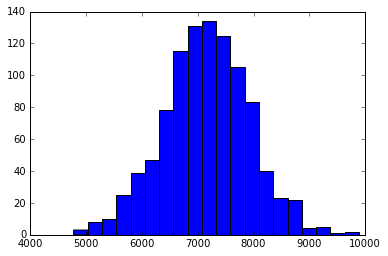

In [190]:
y = []
x = AttendanceGenerator(room_stack=[],time_range=10800)
for i in range(1000):
    #y.append(x.lifts[0].gen_close_door())
    #print(i)
    y.append(x.generate())
plt.hist(y,bins=20)

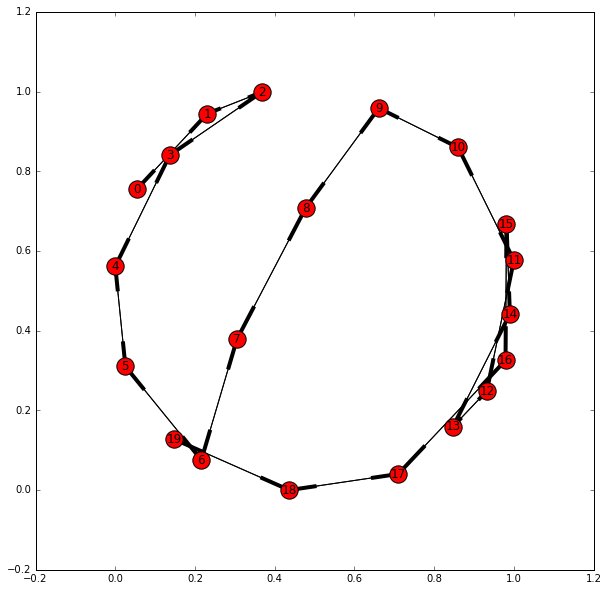

In [203]:
one_lift = create_lift(20)
plt.figure(figsize=(10,10))
nx.draw_networkx(one_lift,pos=nx.spring_layout(one_lift))
plt.show()

In [23]:
# make a graph network of the floor
lifts_graph = []
for x in range(lift_number):
    lifts_graph.append(create_lift(number_of_floor))

In [24]:
lifts_graph